In [1]:
import os
import random

import graphviz
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sk

%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
np.random.seed(42)

# Utility Functions
---

In [2]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize = (17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first = False).values
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = sk.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = sk.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves')

    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
        
    ax.legend(loc = "best")
    ax.grid(alpha = .4)
    sns.despine()
    plt.show();

In [33]:
def get_confusion_matrix(y_test, y_pred):
  sk.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.grid(visible = None)
  plt.show();

In [4]:
def print_performance_metrics(eval_set, classifier_preds):
    print("Confusion Matrix:")
    print(sk.confusion_matrix(eval_set, classifier_preds), "\n")
    print("Classification Report:")
    print(sk.classification_report(eval_set, classifier_preds), "\n")
    print("Accuracy:", sk.accuracy_score(eval_set, classifier_preds))

# Exploring the Body Performance dataset from Kaggle
## Target variable is "class": grade of performance based on provided data, A is best, D is worst...
## "Systolic" and "Diastolic" refer to blood pressure measures.

 https://www.kaggle.com/kukuroo3/body-performance-data
 
----

In [5]:
performance_df = pd.read_csv("./bodyPerformance.csv")

In [6]:
performance_df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [7]:
performance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [8]:
performance_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,13393.0,36.775106,13.625639,21.0,25.0,32.0,48.0,64.0
height_cm,13393.0,168.559807,8.426583,125.0,162.4,169.2,174.8,193.8
weight_kg,13393.0,67.447316,11.949666,26.3,58.2,67.4,75.3,138.1
body fat_%,13393.0,23.240165,7.256844,3.0,18.0,22.8,28.0,78.4
diastolic,13393.0,78.796842,10.742033,0.0,71.0,79.0,86.0,156.2
systolic,13393.0,130.234817,14.713954,0.0,120.0,130.0,141.0,201.0
gripForce,13393.0,36.963877,10.624864,0.0,27.5,37.9,45.2,70.5
sit and bend forward_cm,13393.0,15.209268,8.456677,-25.0,10.9,16.2,20.7,213.0
sit-ups counts,13393.0,39.771224,14.276698,0.0,30.0,41.0,50.0,80.0
broad jump_cm,13393.0,190.129627,39.868000,0.0,162.0,193.0,221.0,303.0


### There are 13,393 observations in the dataset with no missing values. The data seems to be relatively accurate, the only exception being the minimum value of "sit and bend forward_cm" at -25. It does not really make sense for this value to be negative.

## Converting height to feet, weight to pounds...

In [9]:
performance_df["height_cm"] = performance_df["height_cm"].apply(lambda x: x / 30.48)
performance_df["weight_kg"] = performance_df["weight_kg"].apply(lambda x: x * 2.2)

performance_df.rename(columns = {"height_cm" : "height_ft", "weight_kg" : "weight_lbs", "class" : "Performance Grade"}, inplace = True)

In [10]:
performance_df.sample(1)

,age,gender,height_ft,weight_lbs,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Performance Grade
10635,21.0,F,5.492126,158.796,40.0,82.0,133.0,18.7,-4.0,21.0,94.0,D


# Exploratory Data Analysis
----

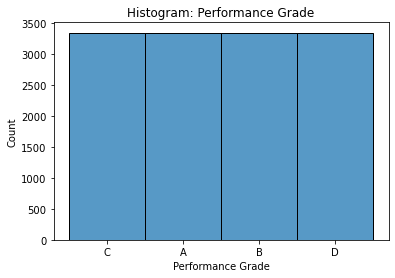

In [11]:
sns.histplot(performance_df["Performance Grade"]).set_title("Histogram: Performance Grade");

### With respect to the target variable the classes are balanced.

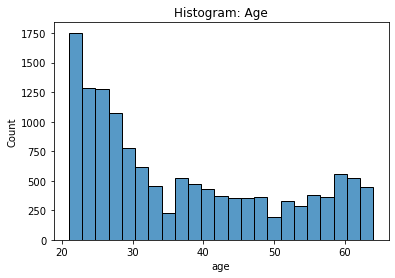

In [12]:
sns.histplot(performance_df.age).set_title("Histogram: Age");

### The age is a bit skewed to the right, this is somewhat sensible though as younger people are more likely to partake in an evaluation on exercise performance.

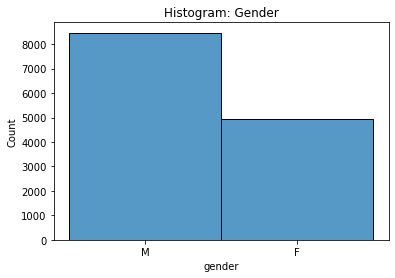

In [13]:
sns.histplot(performance_df.gender).set_title("Histogram: Gender");

### There are roughly 3,000 more males in the dataset compared to females.

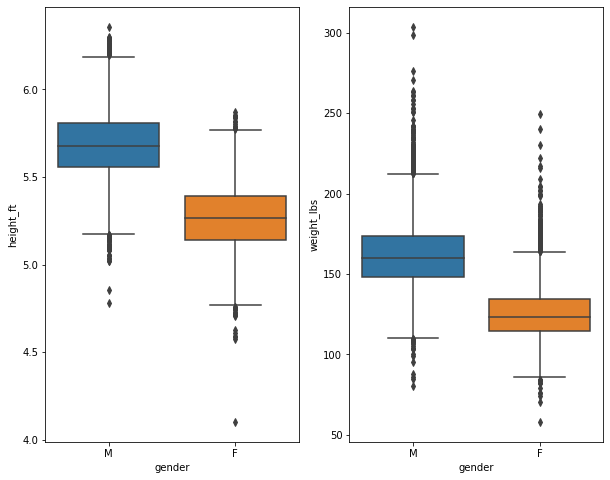

In [14]:
plt.figure(figsize = (10, 8))

ax = plt.subplot(1, 2, 1)
sns.boxplot(x = "gender", y = "height_ft", data = performance_df, ax = ax)

ax = plt.subplot(1, 2, 2)
sns.boxplot(x = "gender", y = "weight_lbs", data = performance_df, ax = ax);

### There are quite a few outliers for both genders with respect to both height and weight. Given that height can be attributed to genetics and weight can depend on a number of factors, I believe it is best not to remove them at this time. Removing them later may improve predictive performance, but let's hold off for now.

### We can observe that males tend to be both taller and heavier than females, though.

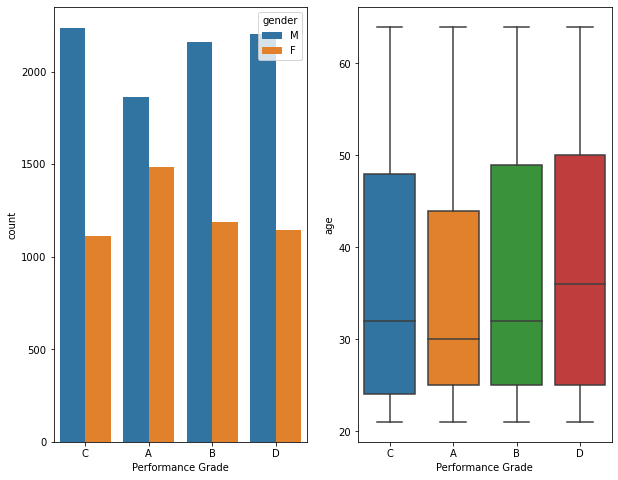

In [15]:
plt.figure(figsize = (10, 8))

ax = plt.subplot(1, 2, 1)
sns.countplot(x = "Performance Grade", hue = "gender", data = performance_df, ax = ax)

ax = plt.subplot(1, 2, 2)
sns.boxplot(x = "Performance Grade", y = "age", data = performance_df, ax = ax);

In [16]:
performance_df.groupby("Performance Grade")["age"].mean()

Performance Grade
A    35.268220
B    37.074096
C    36.699612
D    38.058226
Name: age, dtype: float64

### With respect to the performance grade, it can be observed that the distribution amongst the various grades for each gender is somewhat evenly distributed. In addition, the average age for each grade is roughly the same.

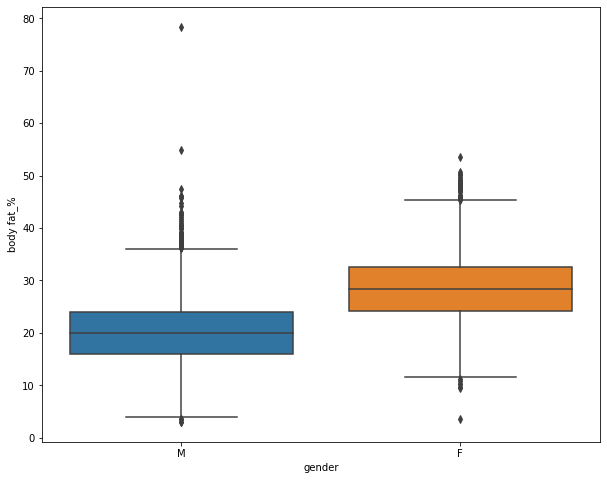

In [17]:
plt.figure(figsize = (10, 8))

sns.boxplot(x = "gender", y = "body fat_%", data = performance_df);

### Interestingly, females tend to have a higher body fat percentage at an average of about 30%, compared to males with an average of approximately 20%. There is a considerable outlier for males, however, at almost 80% body fat.

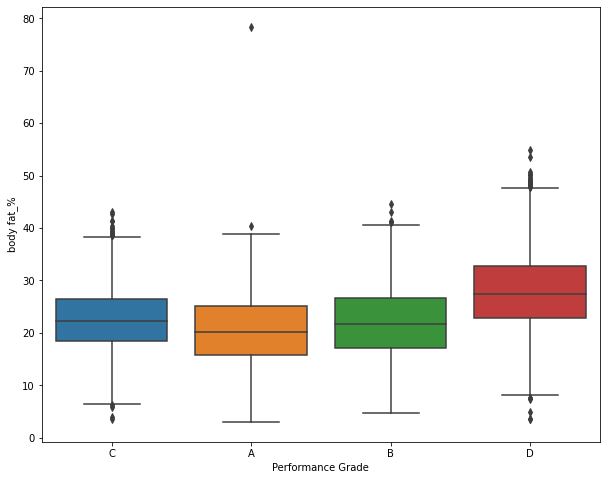

In [18]:
plt.figure(figsize = (10, 8))

sns.boxplot(x = "Performance Grade", y = "body fat_%", data = performance_df);

### Unsurprisingly, it can be observed that the lower performance grades belong to individuals with higher body fat percentages.

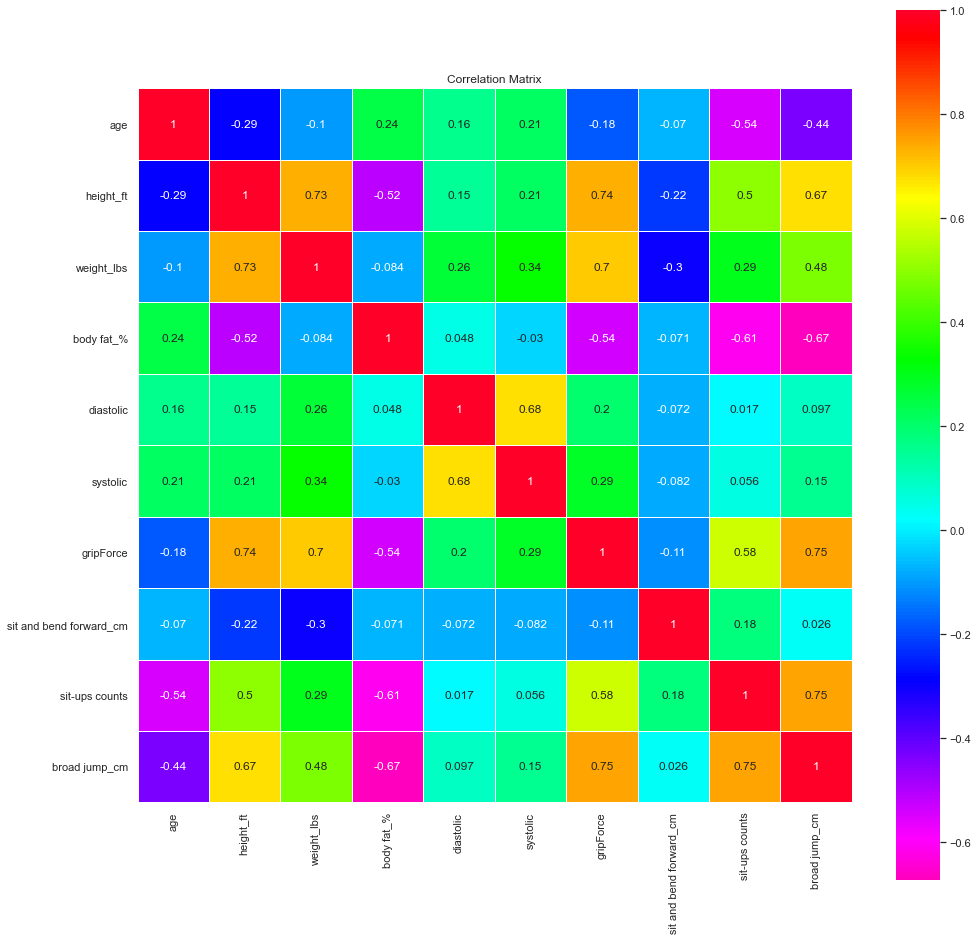

In [19]:
plt.figure(figsize = (16, 16))
sns.set(font_scale = 1)
sns.heatmap(performance_df.corr(), cmap = "gist_rainbow_r", annot = True, square = True, linewidths = .5)
plt.title("Correlation Matrix");

### The correlation matrix provides a fair amount of insights.

1). Broad Jump is positively correlated with both grip force and sit-up count, could be indicative of overall physical condition/performance.

2). Grip Force is positively correlated with height and weight, indicating that taller/heavier individuals are stronger, to a certain degree.
3). Body fat percentage is negatively correlated with height, grip force, sit-up count and broad-jump. This is sensible as it is more difficult to maintain a lower body fat percentage at a shorter height and body fat percentage can be seen as a measure of physical condition/performance to a certain degree.

4). Height and weight are of course positively correlated.

5). Age is negatively correlated with the exercise performance metrics.

# One-Hot Encoding, Standardizing, and Splitting the Data
----

In [20]:
# Male -> 0, Female -> 1
performance_df.loc[performance_df["gender"] == "M", "gender"] = 0
performance_df.loc[performance_df["gender"] == "F", "gender"] = 1

In [21]:
target_arr = performance_df["Performance Grade"].values
features_arr = performance_df.drop(columns = ["Performance Grade"], axis = 1).values

In [22]:
sc = StandardScaler()

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Training set is now 70% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(features_arr, target_arr, test_size = 1 - train_ratio, random_state = 42)

# Test set is now 15% of the initial data set
# Validation set is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = test_ratio/(test_ratio + validation_ratio), random_state = 42) 

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [23]:
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

X_train: (9375, 11)
X_val: (2009, 11)
X_test: (2009, 11)
y_train: (9375,)
y_val: (2009,)
y_test: (2009,)


# Predictive Modeling
---

## Linear SVM
---

In [24]:
lin_svc_clf = SVC(kernel = "linear")
lin_svc_clf.fit(X_train, y_train)

SVC(kernel='linear')

In [25]:
y_pred_lin_svc_clf = lin_svc_clf.predict(X_val)

In [26]:
print("Evaluating on Validation Set Data (Linear SVM):\n")
print_performance_metrics(y_val, y_pred_lin_svc_clf)

Evaluating on Validation Set Data (Linear SVM):

Confusion Matrix:
[[365 132   3   0]
 [105 247 120  18]
 [ 44 113 268  57]
 [ 13  34  81 409]] 

Classification Report:
              precision    recall  f1-score   support

           A       0.69      0.73      0.71       500
           B       0.47      0.50      0.49       490
           C       0.57      0.56      0.56       482
           D       0.85      0.76      0.80       537

    accuracy                           0.64      2009
   macro avg       0.64      0.64      0.64      2009
weighted avg       0.65      0.64      0.64      2009
 

Accuracy: 0.6416127426580388


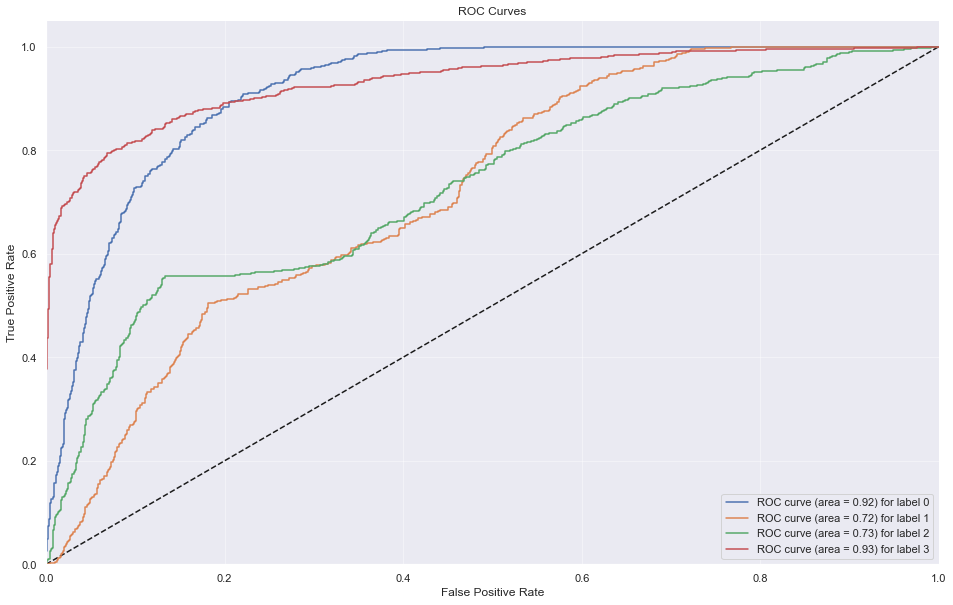

In [35]:
plot_multiclass_roc(lin_svc_clf, X_val, y_val, n_classes = 4, figsize = (16, 10))

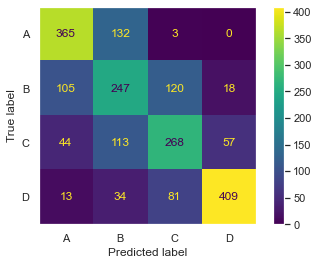

In [34]:
get_confusion_matrix(y_val, y_pred_lin_svc_clf)

### Overall, the SVM with a linear kernel does not perform very well when evaluated on the validation set at 64% accuracy. The classifier performs best when classifying samples from the A and D classes, though, representing the extremes.

## Polynomial SVM
---

In [36]:
poly_svc_clf = SVC(kernel = "poly")
poly_svc_clf.fit(X_train, y_train)

SVC(kernel='poly')

In [37]:
y_pred_poly_svc_clf = poly_svc_clf.predict(X_val)

In [39]:
print("Evaluating on Validation Set Data (Polynomial SVM):\n")
print_performance_metrics(y_val, y_pred_poly_svc_clf)

Evaluating on Validation Set Data (Polynomial SVM):

Confusion Matrix:
[[346 140  14   0]
 [ 89 240 148  13]
 [ 43 106 318  15]
 [ 10  34 120 373]] 

Classification Report:
              precision    recall  f1-score   support

           A       0.71      0.69      0.70       500
           B       0.46      0.49      0.48       490
           C       0.53      0.66      0.59       482
           D       0.93      0.69      0.80       537

    accuracy                           0.64      2009
   macro avg       0.66      0.63      0.64      2009
weighted avg       0.66      0.64      0.64      2009
 

Accuracy: 0.6356396217023395


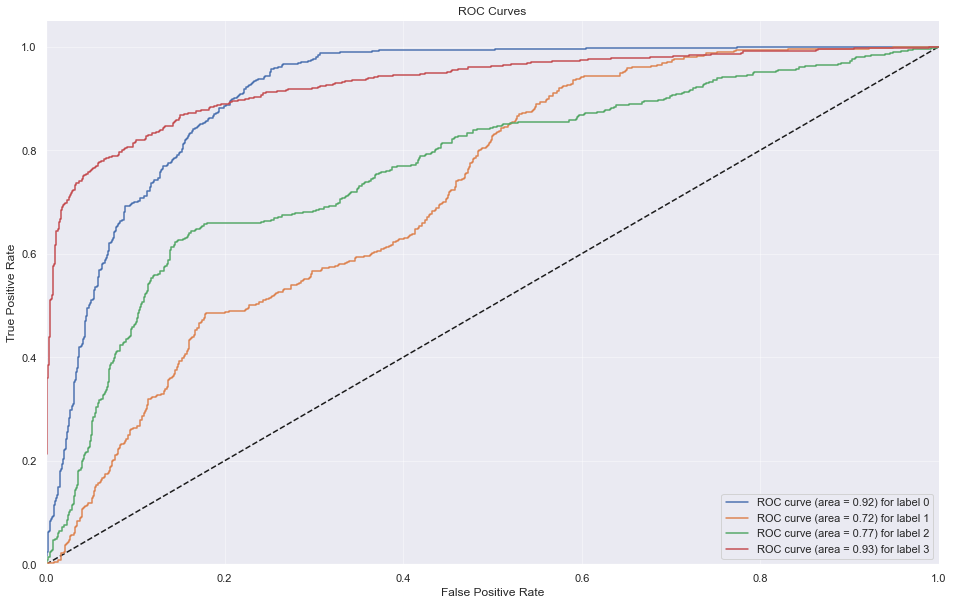

In [40]:
plot_multiclass_roc(poly_svc_clf, X_val, y_val, n_classes = 4, figsize = (16, 10))

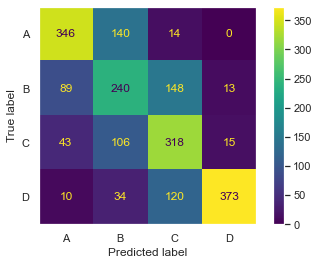

In [41]:
get_confusion_matrix(y_val, y_pred_poly_svc_clf)

### Overall performance is slightly down, classifier is performing better at classifying samples from the "C" class, though.

## RBF Kernel SVM
---

In [42]:
rbf_svc_clf = SVC(kernel = "rbf")
rbf_svc_clf.fit(X_train, y_train)

SVC()

In [43]:
y_pred_rbf_svc_clf = rbf_svc_clf.predict(X_val)

In [47]:
print("Evaluating on Validation Set Data (RBF SVM):\n")
print_performance_metrics(y_val, y_pred_rbf_svc_clf)

Evaluating on Validation Set Data (RBF SVM):

Confusion Matrix:
[[378 118   2   2]
 [ 97 286  92  15]
 [ 37 102 319  24]
 [ 10  34  75 418]] 

Classification Report:
              precision    recall  f1-score   support

           A       0.72      0.76      0.74       500
           B       0.53      0.58      0.56       490
           C       0.65      0.66      0.66       482
           D       0.91      0.78      0.84       537

    accuracy                           0.70      2009
   macro avg       0.70      0.69      0.70      2009
weighted avg       0.71      0.70      0.70      2009
 

Accuracy: 0.6973618715778994


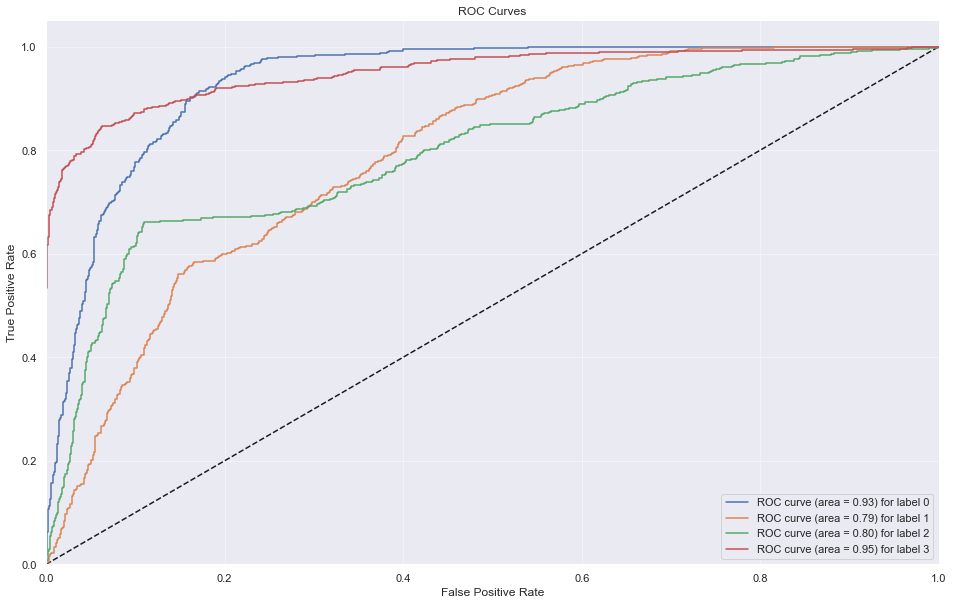

In [45]:
plot_multiclass_roc(rbf_svc_clf, X_val, y_val, n_classes = 4, figsize = (16, 10))

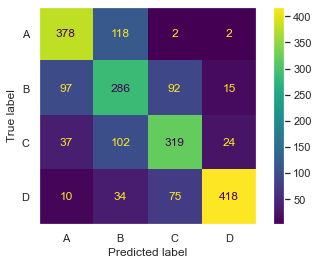

In [46]:
get_confusion_matrix(y_val, y_pred_rbf_svc_clf)

### Performance is now up to 70% accuracy. This bump in performance is mainly coming from improved accuracy at classifying samples from the "B" and "C" classes.

### Overall, SVMs do not seem to be the best option for this particular dataset, other models should be explored.

## Decision Trees
---

## DT w/ Entropy as Impurity Measure
---

In [48]:
entropy_dt_clf = DecisionTreeClassifier(criterion = "entropy", random_state = 42)
entropy_dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [49]:
y_pred_edt = entropy_dt_clf.predict(X_val)

In [50]:
print("Evaluating on Validation Set Data (Decision Tree with Entropy):\n")
print_performance_metrics(y_val, y_pred_edt)

Evaluating on Validation Set Data (Decision Tree with Entropy):

Confusion Matrix:
[[349  98  44   9]
 [ 93 248 110  39]
 [ 42 108 275  57]
 [ 10  38  61 428]] 

Classification Report:
              precision    recall  f1-score   support

           A       0.71      0.70      0.70       500
           B       0.50      0.51      0.51       490
           C       0.56      0.57      0.57       482
           D       0.80      0.80      0.80       537

    accuracy                           0.65      2009
   macro avg       0.64      0.64      0.64      2009
weighted avg       0.65      0.65      0.65      2009
 

Accuracy: 0.6470881035340965


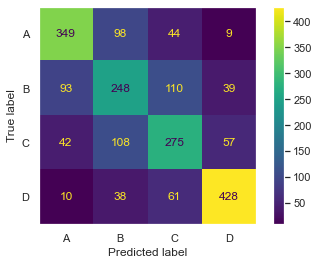

In [52]:
get_confusion_matrix(y_val, y_pred_edt)

## DT w/ Gini as Impurity Measure
---

In [53]:
gini_dt_clf = DecisionTreeClassifier(criterion = "gini", random_state = 42)
gini_dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [54]:
y_pred_gdt = gini_dt_clf.predict(X_val)

In [55]:
print("Evaluating on Validation Set Data (Decision Tree with Entropy):\n")
print_performance_metrics(y_val, y_pred_gdt)

Evaluating on Validation Set Data (Decision Tree with Entropy):

Confusion Matrix:
[[323 124  44   9]
 [ 84 266 101  39]
 [ 37  86 279  80]
 [ 15  35  62 425]] 

Classification Report:
              precision    recall  f1-score   support

           A       0.70      0.65      0.67       500
           B       0.52      0.54      0.53       490
           C       0.57      0.58      0.58       482
           D       0.77      0.79      0.78       537

    accuracy                           0.64      2009
   macro avg       0.64      0.64      0.64      2009
weighted avg       0.65      0.64      0.64      2009
 

Accuracy: 0.6436037829766053


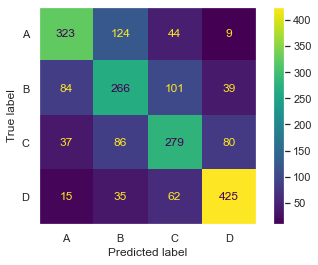

In [56]:
get_confusion_matrix(y_val, y_pred_gdt)

### Both the decision trees perform poorly when evaluated on the validation set.